# Applied Machine Learning homework3

Huibo Zhao hz2480
Lingjie Xu lx2222

# Perform General Data Preprocessing

In [271]:
import os
import pandas as pd
import math
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Extract those files that contain our training data
path = os.getcwd()
files = os.listdir(path)
xlsx_files = [f for f in files if f[-4:] == 'xlsx' and f[0] != '~' and f[0:4] != '2018']

# Putting all the contents into dataframe for viewing and accessing
df = pd.DataFrame()
for f in xlsx_files:
    data = pd.read_excel(f, 'FEguide')
    df = df.append(data)
    
train_row_count = df.shape[0] # record the number of training data

# appending data of 2018
xlsx_test = [f for f in files if f[-4:] == 'xlsx' and f[0] != '~' and f[0:4] == '2018']
test_data = pd.read_excel(xlsx_test[0], 'FEguide')
df = df.append(test_data)

In [3]:
# We extract the target value
y = df['Comb Unrd Adj FE - Conventional Fuel'].as_matrix()

# Examine if the target contains any empty or nan value
# If it does, we need to drop the row without a valid target value
# Fortunately, we don't find such row
for i in y:
    if isinstance(i,float) and math.isnan(i):
        print(i)

In [4]:
dropout_features = list()


# Professor had named a few features that we cannot use, we extract the name of those features
da = np.array(df.columns)
drop_index = list()
for i in range(len(da)):
    if "FE" in da[i]:
        drop_index.append(da[i])
    elif "MPG" in da[i]:
        drop_index.append(da[i])
    elif "CO2" in da[i]:
        drop_index.append(da[i])
    elif "Smog" in da[i]:
        drop_index.append(da[i])
    elif "Guzzler" in da[i]:
        drop_index.append(da[i])
    elif "EPA" in da[i]:
        drop_index.append(da[i])
    elif "GHG" in da[i]:
        drop_index.append(da[i])

dropout_features.extend(drop_index)
df_1 = df.drop(drop_index, axis=1) ##########first drop : drop disallowed features##########
############################################################################################

# We examine each feature and count how many nan values it have
# Save results in a dictionary

column_names = df_1.columns.values
nan_dict = {}

for column_name in column_names:
    count = 0
    for i in range(0,df_1.shape[0]):
        if isinstance(df_1.iloc[i][column_name],float) and math.isnan(df_1.iloc[i][column_name]):
            count += 1
    nan_dict[column_name] = count
    
drop_2 = list()
for key in nan_dict:
    if nan_dict[key]>=2000:
        drop_2.append(key)

dropout_features.extend(drop_2)
df_2 = df_1.drop(drop_2, axis=1) ##########second drop : drop features without enough valid entry#########
##########################################################################################################

In [5]:
# After the second drop, we left with 48 features
# We found 8 features have at least 1 nan values  
# We have to handle that 
count_dict = {}
column_names = df_2.columns.values
for column_name in column_names:
    count = 0
    for i in range(0,df_2.shape[0]):
        if isinstance(df_2.iloc[i][column_name],float) and math.isnan(df_2.iloc[i][column_name]):
            count += 1
    count_dict[column_name] = count
    
        
for key in count_dict:
    if count_dict[key] > 0:
        print(str(key) + ": " + str(count_dict[key]))


Max Ethanol % - Gasoline: 107
Descriptor - Model Type (40 Char or less): 1391
Car/Truck Category - Cash for Clunkers Bill.: 1690
Unique Label?: 420
Label Recalc?: 248
Var Valve Timing Desc: 151
$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) : 1301


In [6]:
dropout_features.append("Car/Truck Category - Cash for Clunkers Bill.")
df_3 = df_2.drop("Car/Truck Category - Cash for Clunkers Bill.", axis=1) #### third drop ####
####### Car/Truck features is useless after examining it ####################################

dropout_features.append("Release Date") ###### Fourth drop ##################################
df_4 = df_3.drop("Release Date", axis=1) ##### We temporarily drop the date here ############


dropout_features.append("Descriptor - Model Type (40 Char or less)")  ######## fifth drop ###
df_5 = df_4.drop("Descriptor - Model Type (40 Char or less)", axis=1) #######################

#################### We have done all dropping features by this point #######################
#################### All dropout features are stored in dropout_features ####################


In [7]:
################################ We fill out those four features manually ###################
index_ = df_5.columns
adjust_index = list()
adjust_index.append(list(index_).index("Max Ethanol % - Gasoline"))
adjust_index.append(list(index_).index("Unique Label?"))
adjust_index.append(list(index_).index("Label Recalc?"))
adjust_index.append(list(index_).index("Var Valve Timing Desc"))
adjust_index

for i in adjust_index:
    for j in range(df_5.shape[0]):
        if j != df_5.shape[0] - 1:
            if isinstance(df_5.iat[j, i], float) and math.isnan(df_5.iat[j, i]):
                if isinstance(df_5.iat[j + 1, i], float) and math.isnan(df_5.iat[j + 1, i]):
                    df_5.iat[j, i] = df_5.iat[j - 1, i]
                else:
                    m = random.randint(0,1)
                    if m == 0:
                        df_5.iat[j, i] = df_5.iat[j - 1, i]
                    else:
                        df_5.iat[j, i] = df_5.iat[j + 1, i]
        else:
            if isinstance(df_5.iat[j, i],float) and math.isnan(df_5.iat[j, i]):
                df_5.iat[j, i] = df_5.iat[j - 1, i]
##############################################################################################

############################# using get_dummies to fill out discrete features ################
df_6 = pd.get_dummies(df_5)
##############################################################################################

In [8]:
import fancyimpute

############################# using fancy_impute to impute data entries ######################
X = df_6.as_matrix()
mice = fancyimpute.MICE(verbose=0)
X_fancy_mice = mice.complete(X)
#############################################################################################

# We assume the data are distributed i.i.d but we know we are going to use
# 2018 data as test data
X_15_17 = X_fancy_mice[0:train_row_count, :]
X_18 = X_fancy_mice[train_row_count: , :]
y_15_17 = y[0:train_row_count,]
y_18 = y[train_row_count:,]

Using TensorFlow backend.


# Part 1

In [9]:
# Evaluate using lassoCV with standardscaler
lasso_pipe = make_pipeline(StandardScaler(), LassoCV())
lasso_pipe.fit(X_15_17, y_15_17)
lasso_pipe.score(X_18, y_18)

0.82771455385136417

In [230]:
# Non-i.i.d split
X_train, X_val, y_train, y_val = train_test_split(X_15_17, y_15_17, random_state=0)

In [135]:
# i.i.d split
X_train_iid, X_test_iid, y_train_iid, y_test_iid = train_test_split(X_fancy_mice, y, random_state=0)

In [11]:
# evaluate using standardscalar and ridge regression

ridge_pipe_s = make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(ridge_pipe_s, param_grid, cv=10)
grid.fit(X_15_17, y_15_17)


ridge_pipe_s_t = make_pipeline(StandardScaler(), Ridge(alpha=float(grid.best_params_['ridge__alpha'])))

ridge_pipe_s_t.fit(X_15_17, y_15_17)
ridge_pipe_s_t.score(X_18, y_18)

0.88657010983991313

In [12]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas = GridSearchCV(ridge_pipe_s_mas, param_grid_mas, cv=10)
grid_mas.fit(X_15_17, y_15_17)

ridge_pipe_s_t_mas = make_pipeline(MaxAbsScaler(), Ridge(alpha=float(grid_mas.best_params_['ridge__alpha'])))

ridge_pipe_s_t_mas.fit(X_15_17, y_15_17)
ridge_pipe_s_t_mas.score(X_18, y_18)

0.95960769335554208

In [25]:
grid_mas.best_score_

0.92830459651393726

In [37]:
ind_selected = np.where(fe >= 1)[0]
len(ind_selected)

242

Use non-iid para parameter to test i.i.d split

In [228]:
grid_mas.score(X_test_iid, y_test_iid)

0.97561096641278111

Part 1 - i.i.d

In [197]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_iid = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_iid = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_iid = GridSearchCV(ridge_pipe_s_mas_iid, param_grid_mas_iid, cv=10)
grid_mas_iid.fit(X_train_iid, y_train_iid)
grid_mas_iid.best_params_

{'ridge__alpha': 0.10000000000000001}

In [198]:
grid_mas_iid.score(X_test_iid, y_test_iid)

0.96008249878013696

# Part2

In [13]:
# evaluate using maxabscaler and ridge regression
fe = ridge_pipe_s_t_mas.steps[1][1].coef_
ind_selected = np.where(fe > 0.7)[0]
ind_original = np.arange(43)
ind_combined = np.concatenate((ind_original,ind_selected),axis=0)
X_15_17_sel = X_15_17[:, ind_combined]
X_18_sel = X_18[:, ind_combined]


'''
ridge_pipe_s_poly = make_pipeline(MaxAbsScaler(), 
                                  PolynomialFeatures(interaction_only=False, include_bias=False), Ridge())

param_grid_poly = {'ridge__alpha': np.logspace(-3, -2 , 1)}
grid_poly = GridSearchCV(ridge_pipe_s_poly, param_grid_poly, cv=10)
grid_poly.fit(X_15_17_sel, y_15_17)
'''

ridge_pipe_s_t_mas_sel = make_pipeline(MaxAbsScaler(),PolynomialFeatures(interaction_only=False, include_bias=False),
                                       #Ridge(alpha=float(grid_poly.best_params_['ridge__alpha'])))
                                       Ridge(alpha=0.03))

ridge_pipe_s_t_mas_sel.fit(X_15_17_sel, y_15_17)
ridge_pipe_s_t_mas_sel.score(X_18_sel, y_18)


0.96145733906346564

# Part 3

In [22]:
# evaluate using maxabscaler and svm
# fe = ridge_pipe_s_t_mas.steps[1][1].coef_
# ind_selected = np.where(fe > 2)[0]
# #ind_selected = np.arange(1000,1050)
# ind_original = np.arange(43)
# #ind_combined = ind_selected
# ind_combined = np.concatenate((ind_original,ind_selected),axis=0)
# X_15_17_sel = X_15_17[:, ind_combined]
# X_18_sel = X_18[:, ind_combined]


svr_pipe_s = make_pipeline(MaxAbsScaler(), SVR())
param_grid = {'svr__C': np.logspace(-3,2,6),
              'svr__gamma': np.logspace(-3,2,6)/X_15_17.shape[0]}
grid = GridSearchCV(svr_pipe_s, param_grid, cv = 2)
grid.fit(X_15_17, y_15_17)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'svr__gamma': array([  2.70197e-07,   2.70197e-06,   2.70197e-05,   2.70197e-04,
         2.70197e-03,   2.70197e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [23]:
grid.best_params_

{'svr__C': 100.0, 'svr__gamma': 0.027019724398811132}

In [24]:
grid.best_score_

0.93048775121195593

In [27]:
svr_pipe_s_t_mas = make_pipeline(MaxAbsScaler(), SVR(C=float(grid.best_params_['svr__C']), gamma=float(grid.best_params_['svr__gamma'])))
svr_pipe_s_t_mas.fit(X_15_17, y_15_17)
svr_pipe_s_t_mas.score(X_18, y_18)

0.96651053095424933

Visualization

In [265]:
grid.cv_results_

{'mean_fit_time': array([  61.0708046 ,   68.39442992,   67.24107039,   70.86885214,
          68.723441  ,   69.68749976,   69.58304179,   69.4842416 ,
          70.26363814,   68.07610118,   64.39787054,   59.2623682 ,
          59.55506873,  150.69886076,   64.00858748,   61.53837693,
          57.77451551,   56.01811206,   57.73719454,   58.06899893,
          60.31106257,   63.64477611,   58.90800738,   62.13929582,
          66.66001332,   91.66144049,   80.88415504,   74.54447353,
          85.40078378,   80.62340951,   82.8042841 ,   72.251724  ,
          74.5618974 ,   77.22663713,   82.4196074 ,   80.73795891]),
 'mean_score_time': array([  58.12999058,   65.57659411,   67.35989404,   66.82124531,
          67.9349972 ,   64.25025153,   64.67175269,   63.92610908,
          68.70982826,   62.52285683,   61.10851943,   54.47047043,
          56.84952033,  109.90298283,   60.43446064,   57.94472361,
          54.30242455,   51.79620445,   55.28309894,   55.67020404,
          

In [268]:
import pandas as pd
res_svr_1 = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_svr__C', columns='param_svr__gamma')
pd.set_option("display.precision",3)
res_svr_1 = res_svr_1.set_index(res_svr_1.index.values.round(6))

Text(33,0.5,'param_C')

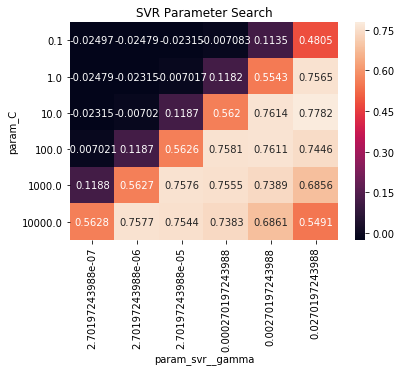

In [273]:
import seaborn as sns
ax = sns.heatmap(res_svr_1, annot=True, fmt=".4g")
ax.set_title('SVR Parameter Search')
ax.set_ylabel('param_C')

SVR - Use StandardScaler

In [130]:
svr_pipe_s_sc = make_pipeline(StandardScaler(), SVR())
param_grid_svr_sc = {'svr__C': np.logspace(-1,4,6),
              'svr__gamma': np.logspace(-3,2,6)/X_15_17.shape[0]}
grid_svr_sc = GridSearchCV(svr_pipe_s_sc, param_grid_svr_sc, cv = 2)
grid_svr_sc.fit(X_15_17, y_15_17)
grid_svr_sc.best_params_

{'svr__C': 10000.0, 'svr__gamma': 0.00027019724398811131}

In [131]:
grid_svr_sc.best_score_

0.93613346254529783

In [132]:
grid_svr_sc.score(X_18, y_18)

0.87184766299813943

Use non-i.i.d parameter to test i.i.d split

In [229]:
grid.score(X_test_iid, y_test_iid)

0.93478781581361459

SVR - Use MaxAbsSclar - i.i.d

In [136]:
svr_pipe_s_iid = make_pipeline(MaxAbsScaler(), SVR())
param_grid_svr_iid = {'svr__C': np.logspace(-1,4,6),
              'svr__gamma': np.logspace(-3,2,6)/X_train_iid.shape[0]}
grid_svr_iid = GridSearchCV(svr_pipe_s_iid, param_grid_svr_iid, cv = 2)
grid_svr_iid.fit(X_train_iid, y_train_iid)
grid_svr_iid.best_params_

{'svr__C': 100.0, 'svr__gamma': 0.027056277056277056}

In [137]:
grid_svr_iid.best_score_

0.96230939165630691

In [138]:
grid_svr_iid.score(X_test_iid, y_test_iid)

0.98230944776862161

# Part 4

Select features from the model in Part 3

In [233]:
from sklearn.feature_selection import SelectFromModel
select_ridgecv = SelectFromModel(RidgeCV(), threshold=1)
select_ridgecv.fit(X_15_17, y_15_17)
print(select_ridgecv.transform(X_15_17).shape)

(2775, 377)


In [53]:
# Apply PolynomialFeatures on the feature selected
svr_pipe_s_fe = make_pipeline(MaxAbsScaler(), select_ridgecv, PolynomialFeatures(), SVR())

In [54]:
param_grid_fe = {'svr__C': np.logspace(-1,4,6),
              'svr__gamma': np.logspace(-3,2,6)/X_15_17.shape[0]}
grid = GridSearchCV(svr_pipe_s_fe, param_grid_fe, cv = 2)
grid.fit(X_15_17, y_15_17)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('selectfrommodel', SelectFromModel(estimator=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False),
        norm_order=1, prefit=False, threshold=1)), ('polynomialfeatu... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': array([  1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04]), 'svr__gamma': array([  2.70197e-07,   2.70197e-06,   2.70197e-05,   2.70197e-04,
         2.70197e-03,   2.70197e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
grid.best_params_

{'svr__C': 10.0, 'svr__gamma': 0.027019724398811132}

In [56]:
grid.best_score_

0.77823704146241601

In [58]:
grid.score(X_18, y_18)

0.93118476805988526

In [234]:
# svr_pipe_s_t_mas_poly = make_pipeline(MaxAbsScaler(), select_ridgecv, PolynomialFeatures(), SVR(C=float(grid.best_params_['svr__C']), gamma=float(grid.best_params_['svr__gamma'])))
# svr_pipe_s_t_mas_poly.fit(X_15_17, y_15_17)
# svr_pipe_s_t_mas_poly.score(X_18, y_18)

0.93118476805988526

RFECV

In [237]:
from sklearn.feature_selection import RFECV, RFE
rfe = RFE(Ridge(), n_features_to_select=200)
rfe.fit(X_15_17, y_15_17)
print(rfe.transform(X_15_17).shape)

(3701, 200)


In [238]:
X_15_17_200_f = rfe.transform(X_15_17)
X_18_200_f = rfe.transform(X_18)

In [239]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_200 = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_200 = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_200 = GridSearchCV(ridge_pipe_s_mas_200, param_grid_mas_200, cv=10)
grid_mas_200.fit(X_15_17_200_f, y_15_17)
grid_mas_200.score(X_18_200_f, y_18)

0.91871978076953043

In [240]:
grid_mas_200.best_params_

{'ridge__alpha': 0.01}

In [241]:
rfe_400 = RFE(Ridge(), n_features_to_select=400)
rfe_400.fit(X_15_17, y_15_17)
print(rfe_400.transform(X_15_17).shape)

(3701, 400)


In [242]:
X_15_17_400_f = rfe_400.transform(X_15_17)
X_18_400_f = rfe_400.transform(X_18)

In [243]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_400 = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_400 = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_400 = GridSearchCV(ridge_pipe_s_mas_400, param_grid_mas_400, cv=10)
grid_mas_400.fit(X_15_17_400_f, y_15_17)
grid_mas_400.score(X_18_400_f, y_18)

0.93953460812625911

In [251]:
rfe_500 = RFE(Ridge(), n_features_to_select=500)
rfe_500.fit(X_15_17, y_15_17)
print(rfe_500.transform(X_15_17).shape)

(3701, 500)


In [252]:
X_15_17_500_f = rfe_500.transform(X_15_17)
X_18_500_f = rfe_500.transform(X_18)

In [253]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_500 = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_500 = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_500 = GridSearchCV(ridge_pipe_s_mas_500, param_grid_mas_500, cv=10)
grid_mas_500.fit(X_15_17_500_f, y_15_17)
grid_mas_500.score(X_18_500_f, y_18)

0.94264883856957238

In [244]:
rfe_600 = RFE(Ridge(), n_features_to_select=600)
rfe_600.fit(X_15_17, y_15_17)
print(rfe_600.transform(X_15_17).shape)

(3701, 600)


In [245]:
X_15_17_600_f = rfe_600.transform(X_15_17)
X_18_600_f = rfe_600.transform(X_18)

In [246]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_600 = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_600 = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_600 = GridSearchCV(ridge_pipe_s_mas_600, param_grid_mas_600, cv=10)
grid_mas_600.fit(X_15_17_600_f, y_15_17)
grid_mas_600.score(X_18_600_f, y_18)

0.94934565152819872

In [255]:
rfe_600.ranking_[0:5]

array([ 742, 1007,    1,  793,  754])

In [262]:
df_6.columns[754]

'Carline_IS 300 AWD'

Important features: Carline, Index (Model Type Index)

In [247]:
rfe_1500 = RFE(Ridge(), n_features_to_select=1500)
rfe_1500.fit(X_15_17, y_15_17)
print(rfe_1500.transform(X_15_17).shape)

(3701, 1500)


In [248]:
X_15_17_1500_f = rfe_1500.transform(X_15_17)
X_18_1500_f = rfe_1500.transform(X_18)

In [250]:
# evaluate using maxabsscaler and ridge regression

ridge_pipe_s_mas_1500 = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_1500 = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid_mas_1500 = GridSearchCV(ridge_pipe_s_mas_1500, param_grid_mas_1500, cv=10)
grid_mas_1500.fit(X_15_17_1500_f, y_15_17)
grid_mas_1500.score(X_18_1500_f, y_18)

0.95270668942566716

SelectKBest

In [ ]:
# from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
# select_200 = SelectKBest(k=200, score_func=f_regression)
# select_200.fit(X_15_17, y_15_17)
# print(X_15_17.shape)
# print(select_200.transform(X_15_17).shape)

In [ ]:
# select_200.get_support(indices=True)

In [ ]:
# select_500 = SelectKBest(k=500, score_func=f_regression)
# select_500.fit(X_15_17, y_15_17)
# print(X_15_17.shape)
# print(select_500.transform(X_15_17).shape)

In [ ]:
# select_500.get_support(indices=True)

Do some try on polynomial features mannually.

In [63]:
df_5.to_csv('df_5.csv')

In [64]:
df_6.to_csv('df_6.csv')

In [87]:
def find_num_index(index, df):
    index_ = list(df.columns)
    adjust_index = list()
    for i in index:
        adjust_index.append(index_.index(i))
    return adjust_index

In [88]:
cols_5 = df_5.columns
cols_5

Index(['Model Year', 'Mfr Name', 'Division', 'Carline', 'Verify Mfr Cd',
       'Index (Model Type Index)', 'Eng Displ', '# Cyl', 'Transmission',
       'Air Aspiration Method Desc', 'Trans', 'Trans Desc', '# Gears',
       'Lockup Torque Converter', 'Trans Creeper Gear', 'Drive Sys',
       'Drive Desc', 'Max Ethanol % - Gasoline',
       'Fuel Usage  - Conventional Fuel',
       'Fuel Usage Desc - Conventional Fuel', 'Fuel Unit - Conventional Fuel',
       'Fuel Unit Desc - Conventional Fuel',
       'Annual Fuel1 Cost - Conventional Fuel', 'Intake Valves Per Cyl',
       'Exhaust Valves Per Cyl', 'Carline Class', 'Carline Class Desc',
       'Calc Approach Desc', 'Unique Label?', 'Label Recalc?', 'Suppressed?',
       'Police/Emerg?', 'Cyl Deact?', 'Var Valve Timing?',
       'Var Valve Timing Desc', 'Var Valve Lift?', 'Fuel Metering Sys Cd',
       'Fuel Metering Sys Desc', 'Camless Valvetrain (Y or N)',
       'Oil Viscosity', 'Stop/Start System (Engine Management System) Code',
 

In [93]:
num_cols = df_5._get_numeric_data().columns
num_cols

Index(['Model Year', 'Index (Model Type Index)', 'Eng Displ', '# Cyl',
       '# Gears', 'Max Ethanol % - Gasoline',
       'Annual Fuel1 Cost - Conventional Fuel', 'Intake Valves Per Cyl',
       'Exhaust Valves Per Cyl', 'Carline Class',
       '$ You Spend over 5 years (increased amount spent in fuel costs over 5 years - on label) '],
      dtype='object')

In [127]:
num_features = find_num_index(num_cols, df_5)
num_features

[0, 5, 6, 7, 12, 17, 22, 23, 24, 25, 42]

In [96]:
cat_cols = list(set(cols_5) - set(num_cols_5))

In [99]:
cat_features = find_num_index(cat_cols, df_5)

In [115]:
from sklearn.pipeline import FeatureUnion, Pipeline
class ColumnExtractor(object):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cols = X[:, self.columns]
        return X_cols

In [116]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# pipeline_self = Pipeline([
#     ('features', FeatureUnion([
#         ('num_feature', Pipeline([
#             ('extract', ColumnExtractor(columns=['num_feature'])),
#             ('poly', PolynomialFeatures(degree=2))
#         ])),
#         ('cat_feature', Pipeline([
#             ('extract', ColumnExtractor(columns=['cat_feature'])),
#             ('le', LabelEncoder()),
#             ('ohe', OneHotEncoder()),
#         ]))
#     ])),
#     ('estimator', RidgeCV())
# ])
pipeline_self = Pipeline([
    ('features', FeatureUnion([
        ('num_feature', Pipeline([
            ('extract', ColumnExtractor(columns=num_features)),
            ('poly', PolynomialFeatures(degree=2))
        ])),
        ('cat_feature', Pipeline([
            ('extract', ColumnExtractor(columns=cat_features)),
            ('le', LabelEncoder()),
            ('ohe', OneHotEncoder()),
        ]))
    ]))
])

In [117]:
pipeline_self.fit(X_df_5)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [103]:
X_fancy_mice[:,10]

array([ 2179.72094459,  9250.        ,  6750.        , ...,  6000.        ,
        2000.        ,  2500.        ])

In [111]:
X_df_5 = df_5.as_matrix()
X_df_5[:,42] = X_fancy_mice[:,10]

In [124]:
X_5_scaled = StandardScaler().fit_transform(X_df_5[:,num_features])
X_5_poly_self = PolynomialFeatures().fit_transform(X_5_scaled)
print(X_5_poly_self.shape)
print(X_5_scaled.shape)

(4928, 78)
(4928, 11)


/Users/xlj/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [129]:
X_5_poly_self[:,0]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [128]:
X_df_5[:,num_features][:,0]

array([2015, 2015, 2015, ..., 2018, 2018, 2018], dtype=object)

In [139]:
X_df_5[:,cat_features].shape

(4928, 32)

In [143]:
df_7 = pd.DataFrame(X_df_5[:,cat_features])

In [149]:
df_8 = pd.get_dummies(df_7)

In [150]:
X_df_8 = df_8.as_matrix()

In [153]:
X_df_8.shape

(4928, 1755)

In [151]:
X_poly_whole_self = np.concatenate((X_5_poly_self, X_df_8), axis=1)

In [152]:
X_poly_whole_self.shape

(4928, 1833)

In [169]:
X_15_17_poly_self = X_poly_whole_self[0:train_row_count, :]
X_18_poly_self = X_poly_whole_self[train_row_count: , :]
y_15_17_poly_self = y[0:train_row_count,]
y_18_poly_self = y[train_row_count:,]

In [170]:
y_15_17_poly_self.shape

(3701,)

In [187]:
ridge_pipe_s_mas_poly = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_poly = {'ridge__alpha': np.logspace(-3, 3, 13)}
grid_mas_poly = GridSearchCV(ridge_pipe_s_mas_poly, param_grid_mas_poly, cv=10)
grid_mas_poly.fit(X_15_17_poly_self, y_15_17_poly_self)
grid_mas_poly.best_params_

{'ridge__alpha': 0.10000000000000001}

In [188]:
grid_mas_poly.best_score_

0.97601353974991145

In [189]:
grid_mas_poly.score(X_18_poly_self, y_18_poly_self)

0.54891585020223832

In [190]:
grid_mas_poly.cv_results_

{'mean_fit_time': array([ 0.43382468,  0.40531704,  0.36954544,  0.37719791,  0.37733085,
         0.36587448,  0.3744715 ,  0.36696093,  0.4274914 ,  0.50571003,
         0.40649414,  0.37924037,  0.37432308]),
 'mean_score_time': array([ 0.00296574,  0.00295224,  0.00295286,  0.00282795,  0.00287886,
         0.00262549,  0.002826  ,  0.00281727,  0.00341382,  0.00376258,
         0.00317035,  0.00291281,  0.00316083]),
 'mean_test_score': array([ 0.96723281,  0.96982325,  0.97253229,  0.97491692,  0.97601354,
         0.97459553,  0.97034461,  0.96064764,  0.94143526,  0.90911797,
         0.85482101,  0.76112815,  0.61131695]),
 'mean_train_score': array([ 0.99672016,  0.99671131,  0.99668511,  0.99658803,  0.99622211,
         0.99511931,  0.99216671,  0.98454554,  0.96849932,  0.94193901,
         0.8998898 ,  0.82483922,  0.69471212]),
 'param_ridge__alpha': masked_array(data = [0.001 0.0031622776601683794 0.01 0.031622776601683791 0.10000000000000001
  0.31622776601683794 1.0 3

In [186]:
ridge_pipe_s_t_mas_poly = make_pipeline(MaxAbsScaler(), Ridge(alpha=20.0))

ridge_pipe_s_t_mas_poly.fit(X_15_17_poly_self, y_15_17_poly_self)
ridge_pipe_s_t_mas_poly.score(X_18_poly_self, y_18_poly_self)

0.90374932711819811

In [191]:
X_train_iid_poly, X_test_iid_poly, y_train_iid_poly, y_test_iid_poly = train_test_split(X_poly_whole_self, y, random_state=0)

In [192]:
X_train_iid_poly.shape

(3696, 1833)

In [193]:
ridge_pipe_s_mas_poly_iid = make_pipeline(MaxAbsScaler(), Ridge())
param_grid_mas_poly_iid = {'ridge__alpha': np.logspace(-3, 3, 13)}
grid_mas_poly_iid = GridSearchCV(ridge_pipe_s_mas_poly_iid, param_grid_mas_poly_iid, cv=10)
grid_mas_poly_iid.fit(X_train_iid_poly, y_train_iid_poly)
grid_mas_poly_iid.best_params_

{'ridge__alpha': 0.31622776601683794}

In [195]:
grid_mas_poly_iid.score(X_test_iid_poly, y_test_iid_poly)

0.98189883577351567

In [199]:
df_7

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,Vehicle Specific 5-cycle label,N,N,GDI,GP,N,Y,Cam Phasers,N,Automated Manual,...,MPG,No,Two Seaters,AM,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Alfa Romeo
1,Derived 5-cycle label,N,N,MFI,GP,N,N,Inlet and Exhaust Cam Phasing,N,Automated Manual,...,MPG,No,Two Seaters,AM,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
2,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Automated Manual,...,MPG,No,Two Seaters,AM,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
3,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Manual,...,MPG,No,Two Seaters,M,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
4,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Automated Manual,...,MPG,No,Two Seaters,AM,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
5,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Manual,...,MPG,No,Two Seaters,M,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
6,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Automated Manual,...,MPG,No,Two Seaters,AM,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
7,Derived 5-cycle label,N,N,MFI,GP,N,N,"Electronically controlled, hydraulically actua...",N,Manual,...,MPG,No,Two Seaters,M,Gasoline (Premium Unleaded Recommended),"2-Wheel Drive, Rear",N,N,N,Aston Martin Lagonda Ltd
8,Vehicle Specific 5-cycle label,N,N,GDI,GP,N,Y,CONTINUOUS INTAKE AND EXHAUST CAM ADJUSTEMENT,N,Automated Manual- Selectable (e.g. Automated M...,...,MPG,No,Two Seaters,AMS,Gasoline (Premium Unleaded Recommended),All Wheel Drive,N,N,N,Audi
9,Vehicle Specific 5-cycle label,N,N,GDI,GP,N,N,CONTINUOUS INTAKE AND EXHAUST CAM ADJUSTEMENT,N,Manual,...,MPG,No,Two Seaters,M,Gasoline (Premium Unleaded Recommended),All Wheel Drive,N,N,N,Audi


In [202]:
X_df_5[:,cat_features][:,0]

array(['Vehicle Specific 5-cycle label', 'Derived 5-cycle label',
       'Derived 5-cycle label', ..., 'Derived 5-cycle label',
       'Derived 5-cycle label', 'Derived 5-cycle label'], dtype=object)

In [203]:
len(X_df_5[:,cat_features][:,0])

4928

In [204]:
len(set(X_df_5[:,cat_features][:,0]))

3

In [205]:
df_8

,0_Derived 5-cycle label,0_Derived Vehicle Specific 5-cycle Calculation Approach for city label but Modified 5-cycle Calculation Approach for Highway label,0_Vehicle Specific 5-cycle label,1_N,1_Y,2_N,2_Y,3_CRDI,3_DDI,3_GDI,...,31_Pagani Automobili S.p.A.,31_Porsche,31_RAM,31_Rolls-Royce Motor Cars Limited,"31_Roush Industries, Inc.",31_SCION,31_Subaru,31_TOYOTA,31_Volkswagen,"31_Volvo Cars of North America, LLC"
0,0,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [207]:
X_df_8[:,0:3]

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [208]:
X_df_cat = X_df_5[:,cat_features]

In [211]:
X_df_num = X_df_5[:,num_features]

In [212]:
X_df_num.shape[1]

11

In [214]:
for j in range(X_df_cat.shape[1]):
    print(len(set(X_df_5[:,cat_features][:,j])))

3
2
2
5
6
2
2
125
2
7
4
6
29
1281
29
2
5
1
109
30
2
1
1
2
23
7
6
5
3
1
2
50


In [ ]:
cat_start_index = 0
return_mat = np.empty([4928,0])
for i in range(X_df_cat.shape[1]):
    n_cat = len(set(X_df_5[:,cat_features][:,j]))
    if n_cat < 10:
        sub_mat = X_df_8[:,cat_start_index:cat_start_index + n_cat]
#         multiply_mat = mp.multiply(sub_mat, X_df_num)

In [222]:
empty_mat = np.empty([4928,0])

In [223]:
XXXXX = np.concatenate((X_df_cat,empty_mat),axis=1)

In [224]:
X_df_cat.shape

(4928, 32)

In [227]:
XXXXX.shape

(4928, 32)